# Step 1: mechanics with Euler-Lagrange

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import logical_and as npand
from numpy import logical_or as npor

In [2]:
from sympy import (symbols, pi, I, E, cos, sin, exp, tan, simplify, expand, factor, collect,
                   apart, cancel, expand_trig, diff, Derivative, Function, integrate, limit,
                   series, Eq, solve, dsolve, Matrix, N, preorder_traversal, Float, solve_linear_system,
                   eye, zeros, lambdify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

In [92]:
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
init_vprinting()

In [4]:
m0, m1, l0, l1, t, g = symbols('m_0 m_1 l_0 l_1 t g')

In [5]:
the1, the2 = dynamicsymbols('theta_1 theta_2')
the1, the2

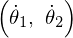

In [6]:
thedot1 = the1.diff(t)
thedot2 = the2.diff(t)
thedot1, thedot2

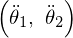

In [7]:
thedotdot1 = thedot1.diff(t)
thedotdot2 = thedot2.diff(t)
thedotdot1, thedotdot2

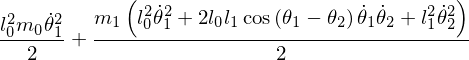

In [8]:
T = m0*l0**2*thedot1**2/2 + m1*(l0**2*thedot1**2 + l1**2*thedot2**2 + 2*l0*l1*thedot1*thedot2*cos(the2-the1))/2
T

In [9]:
U = -m0*g*cos(the1)*l0 - m1*g*(l0*cos(the1)+l1*cos(the2))
U

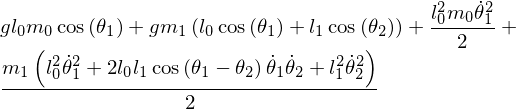

In [10]:
L = T-U
L

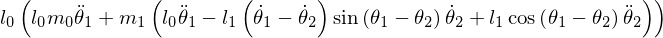

In [11]:
L.diff(thedot1).simplify().diff(t).simplify()

In [12]:
L.diff(the1)

In [13]:
def lagrange(expr, var):
    vardot = var.diff(t)
    lag1 = expr.diff(vardot).simplify().diff(t).simplify()
    lag2 = expr.diff(var).simplify()
    lag = lag1-lag2
    return lag.simplify()

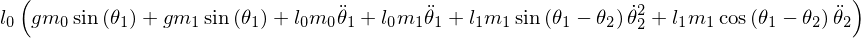

In [14]:
l_expr_1 = lagrange(L, the1)
l_expr_1

## discretization:

$$x_{n+1} = x_n + dt x'$$
$$x' = \frac{x_{n+1}-x_n}{dt}$$

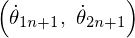

In [15]:
thedot1_1 = dynamicsymbols('theta_1n+1').diff(t)
thedot2_1 = dynamicsymbols('theta_2n+1').diff(t)
thedot1_1, thedot2_1

In [16]:
dt = symbols('dt')

In [17]:
def lagrange_disc(expr, var, params):
    vardot = var.diff(t)
    vardotdot = vardot.diff(t)
    name = var.name
    lag1 = expr.diff(vardot).simplify().diff(t).simplify()
    lag2 = expr.diff(var).simplify()
    lag = (lag1-lag2).simplify()
    vardot_1 = dynamicsymbols(name+'n+1').diff(t)
    dt = symbols('dt')
    lag = lag.subs(vardotdot, (vardot_1-vardot)/dt)
    for para in params:
        parname = para.name
        pardot = para.diff(t)
        pardotdot = pardot.diff(t)
        pardot_1 = dynamicsymbols(parname+'n+1').diff(t)
        lag = lag.subs(pardotdot, (pardot_1-pardot)/dt)
    return lag.simplify()

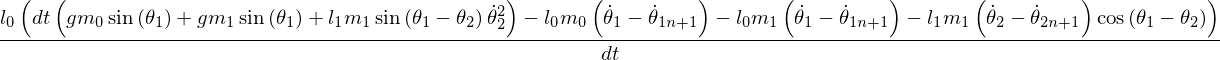

In [18]:
l_expr_1 = lagrange_disc(L, the1, [the2])
l_expr_1

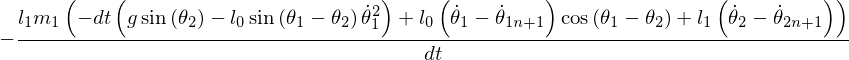

In [19]:
l_expr_2 = lagrange_disc(L, the2, [the1])
l_expr_2

# Step 2: conversion?

In [20]:
import casadi as cas

In [21]:
def sympy2casadi(sympy_expr,sympy_var,casadi_var):
    #import casadi
    assert casadi_var.is_vector()
    if casadi_var.shape[1]>1:
        casadi_var = casadi_var.T
    casadi_var = cas.vertsplit(casadi_var)
    from sympy.utilities.lambdify import lambdify

    mapping = {'ImmutableDenseMatrix': cas.blockcat,
             'MutableDenseMatrix': cas.blockcat,
             'Abs':cas.fabs
            }
    f = lambdify(sympy_var,sympy_expr,modules=[mapping, cas])
    print(casadi_var)
    return f(*casadi_var)

In [22]:
l_sy_vars = [m0, m1, l0, l1, t, dt, g, the1, the2, thedot1, thedot2, thedot1_1, thedot2_1]

In [23]:
x = cas.SX.sym('x', 4)
x_n = cas.SX.sym('x_n', 4)
u = cas.SX.sym('u', 2)
m = cas.SX.sym('m', 2)
l = cas.SX.sym('l', 2)
T = cas.SX.sym("t")
Dt = cas.SX.sym("dt")
G = cas.SX.sym("g")

In [24]:
l_cas_vars = cas.vertcat(m[0],m[1],l[0],l[1],T,Dt,G,x[0],x[1],x[2],x[3],x_n[2], x_n[3])

In [25]:
L_expr_1 = sympy2casadi(l_expr_1, l_sy_vars, l_cas_vars)
L_expr_1

[SX(m_0), SX(m_1), SX(l_0), SX(l_1), SX(t), SX(dt), SX(g), SX(x_0), SX(x_1), SX(x_2), SX(x_3), SX(x_n_2), SX(x_n_3)]


SX(((l_0*((((dt*((((g*m_0)*sin(x_0))-(((sq(x_3)*l_1)*m_1)*sin((x_1-x_0))))+((g*m_1)*sin(x_0))))-((l_0*m_0)*(x_2-x_n_2)))-((l_0*m_1)*(x_2-x_n_2)))-(((l_1*m_1)*(x_3-x_n_3))*cos((x_1-x_0)))))/dt))

In [26]:
L_expr_2 = sympy2casadi(l_expr_2, l_sy_vars, l_cas_vars)
L_expr_2

[SX(m_0), SX(m_1), SX(l_0), SX(l_1), SX(t), SX(dt), SX(g), SX(x_0), SX(x_1), SX(x_2), SX(x_3), SX(x_n_2), SX(x_n_3)]


SX((-(((l_1*m_1)*((((l_0*(x_2-x_n_2))*cos((x_1-x_0)))-(dt*(((sq(x_2)*l_0)*sin((x_1-x_0)))+(g*sin(x_1)))))+(l_1*(x_3-x_n_3))))/dt)))

In [27]:
step_rest_1 = cas.Function('Step_rest_1', [x, x_n, u, Dt, m, l, G], [L_expr_1-u[0]])

In [28]:
step_rest_2 = cas.Function('Step_rest_2', [x, x_n, u, Dt, m, l, G], [L_expr_1-u[1]])

In [58]:
euler_step = cas.Function('Euler_step', [x, Dt], [x[0]+Dt*x[1], x[2]+Dt*x[3]])

In [35]:
N = 200

In [78]:
opti = cas.Opti()
opti.solver('ipopt')

In [79]:
X = opti.variable(N+1,4)
U = opti.variable(N,2)
T = opti.parameter()
u_m = opti.parameter()

In [80]:
M = opti.parameter(2)
L = opti.parameter(2)
G = opti.parameter()

In [81]:
cost = cas.sum1(2+cas.cos(X[:,0])+cas.cos(X[:,2]))*T
opti.minimize(cost)

In [82]:
opti.subject_to(X[0,:].T == [0, 0, 0, 0])
opti.subject_to(cas.cos(X[-1,0]) < -0.9999)
opti.subject_to(cas.cos(X[-1,2]) < -0.9999)
opti.subject_to(opti.bounded(-0.001,X[-1,1],0.001))
opti.subject_to(opti.bounded(-0.001,X[-1,3],0.001))

In [83]:
for ii in range(N):
    _step = euler_step(X[ii,:], T/N)
    opti.subject_to(X[ii+1,0] == _step[0])
    opti.subject_to(X[ii+1,2] == _step[1])
    opti.subject_to(step_rest_1(X[ii,:], X[ii+1,:], U[ii,:], T/N, M, L, G) == 0)
    opti.subject_to(step_rest_2(X[ii,:], X[ii+1,:], U[ii,:], T/N, M, L, G) == 0)
    opti.subject_to(opti.bounded(-u_m,U[ii, 0],u_m))
    opti.subject_to(opti.bounded(-u_m,U[ii, 1],u_m))

In [135]:
opti.set_initial(X[:,0], np.linspace(0, cas.pi, N+1))
opti.set_initial(X[:,2], np.linspace(0, cas.pi, N+1))
opti.set_initial(X[:,1], cas.pi/N)
opti.set_initial(X[:,3], cas.pi/N)
opti.set_value(T, 30)
max_par = 0.1
opti.set_value(u_m, max_par)
opti.set_value(L, [1,1])
opti.set_value(M, [1,1])
opti.set_value(G, [1])

In [136]:
sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4004
Number of nonzeros in inequality constraint Jacobian.:      404
Number of nonzeros in Lagrangian Hessian.............:     1802

Total number of variables............................:     1204
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      804
Total number of inequality constraints...............:      404
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      402
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  89  4.2336383e+03 1.31e+00 2.76e+01  -1.0 6.33e-01   1.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.1732626e+03 3.93e-01 3.83e+01  -1.0 3.25e-01   2.0 1.00e+00 1.00e+00f  1
  91  4.1512957e+03 3.90e-02 2.21e+01  -1.0 9.00e-02   2.4 1.00e+00 1.00e+00f  1
  92  4.0818243e+03 2.48e-01 3.32e+01  -1.0 2.36e-01   1.9 1.00e+00 1.00e+00f  1
  93  3.8503320e+03 2.21e+00 1.09e+02  -1.0 1.35e+00   1.5 9.19e-01 8.67e-01f  1
  94  3.8377530e+03 1.51e+00 2.12e+02  -1.0 3.02e+00   1.9 1.00e+00 1.38e-01f  1
  95  3.7923594e+03 1.29e+00 2.66e+02  -1.0 4.75e-01   2.3 4.55e-01 1.00e+00f  1
  96  3.7825331e+03 2.15e+00 9.34e+02  -1.0 6.31e-01   2.7 1.00e+00 1.00e+00f  1
  97  3.7746212e+03 5.20e-01 3.12e+02  -1.0 2.59e-01   3.2 5.22e-01 1.00e+00f  1
  98  3.7740876e+03 5.00e-01 5.78e+03  -1.0 3.33e-01   3.6 4.08e-01 9.02e-01f  1
  99  3.7739992e+03 4.68e-01 5.62e+03  -1.0 1.62e-01   4.9 1.00e+00 6.52e-02h  1
iter    objective    inf_pr 

 183  2.1647458e+03 4.13e-03 8.60e+01  -1.0 4.81e-02   2.8 9.48e-01 1.00e+00f  1
 184  2.1411525e+03 3.84e-02 2.06e+01  -1.0 9.68e-02   2.3 1.00e+00 1.00e+00f  1
 185  2.0641693e+03 8.89e-01 6.96e+01  -1.0 2.79e-01   1.8 5.33e-01 1.00e+00f  1
 186  2.0224915e+03 8.03e+00 6.73e+02  -1.0 1.40e+00   2.2 2.70e-01 1.00e+00f  1
 187  2.0350873e+03 3.08e+00 1.29e+03  -1.0 7.24e-01   3.6 1.00e+00 7.07e-01h  1
 188  2.0354626e+03 2.97e+00 1.39e+03  -1.0 4.09e-01   4.0 1.00e+00 3.60e-02h  1
 189  2.0444939e+03 5.50e-01 1.22e+03  -1.0 4.26e-01   3.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  2.0469321e+03 2.29e-01 8.62e+02  -1.0 1.33e-01   3.9 1.00e+00 6.81e-01h  1
 191  2.0481613e+03 1.63e-02 3.30e+02  -1.0 1.11e-01   3.5 7.94e-01 1.00e+00h  1
 192  2.0441925e+03 7.54e-03 5.52e+01  -1.0 3.31e-02   3.0 1.00e+00 1.00e+00f  1
 193  2.0339456e+03 3.81e-03 1.64e+01  -1.0 4.33e-02   2.5 1.00e+00 1.00e+00f  1
 194  2.0035236e+03 3.20e-02

 278  1.0618855e+03 4.90e-03 2.99e+00  -1.0 6.13e-02   1.7 1.00e+00 1.00e+00f  1
 279  1.0575846e+03 7.41e-01 1.45e+01  -1.0 3.35e-01   1.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  1.0556966e+03 1.28e-01 1.06e+01  -1.0 2.53e-01   1.6 1.00e+00 1.00e+00f  1
 281  1.0520076e+03 4.70e-02 2.87e+00  -1.0 1.99e-01   1.2 1.00e+00 1.00e+00f  1
 282  1.0505412e+03 2.37e-02 2.82e+00  -1.0 7.32e-02   1.6 1.00e+00 1.00e+00f  1
 283  1.0466268e+03 9.90e-02 2.78e+00  -1.0 2.16e-01   1.1 1.00e+00 1.00e+00f  1
 284  1.0368011e+03 1.12e+01 3.94e+00  -1.0 1.18e+00   0.6 1.00e+00 1.00e+00f  1
 285  1.0332260e+03 1.24e+00 7.70e+00  -1.0 7.29e-01   1.1 1.00e+00 1.00e+00h  1
 286  1.0326376e+03 3.12e-01 1.17e+01  -1.0 2.43e-01   1.5 1.00e+00 1.00e+00h  1
 287  1.0292799e+03 1.38e-01 4.28e+00  -1.0 2.40e-01   1.0 1.00e+00 1.00e+00f  1
 288  1.0278990e+03 3.58e-02 3.46e+00  -1.0 1.46e-01   1.4 1.00e+00 1.00e+00f  1
 289  1.0242710e+03 8.97e-02

 386  7.5241055e+02 1.19e-04 5.50e-03  -5.7 3.69e-03   0.1 1.00e+00 1.00e+00h  1
 387  7.5240993e+02 1.29e-03 1.14e-02  -5.7 1.71e-02  -0.3 1.00e+00 7.90e-01h  1
 388  7.5240937e+02 5.86e-04 1.26e-02  -5.7 8.93e-03   0.1 1.00e+00 1.00e+00f  1
 389  7.5240901e+02 1.27e-04 1.39e-02  -5.7 4.15e-03   0.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390  7.5240866e+02 4.37e-03 4.17e-02  -5.7 2.47e-02   0.0 1.00e+00 1.00e+00h  1
 391  7.5240525e+02 3.34e-03 9.17e-02  -5.7 2.20e-02   0.5 1.00e+00 1.00e+00h  1
 392  7.5239849e+02 2.07e-03 1.87e-01  -5.7 1.89e-02   0.9 1.00e+00 1.00e+00h  1
 393  7.5238837e+02 1.31e-03 2.97e-01  -5.7 1.38e-02   1.3 1.00e+00 1.00e+00h  1
 394  7.5237986e+02 4.29e-04 4.26e-01  -5.7 8.48e-03   1.7 1.00e+00 1.00e+00h  1
 395  7.5234801e+02 8.49e-03 6.90e-01  -5.7 3.60e-02   1.3 1.00e+00 1.00e+00h  1
 396  7.5232629e+02 8.18e-03 6.41e-01  -5.7 1.07e-01   0.8 1.40e-01 1.68e-01h  1
 397  7.5211302e+02 1.43e-01

In [137]:
xx = sol.value(X)
uu = sol.value(U)

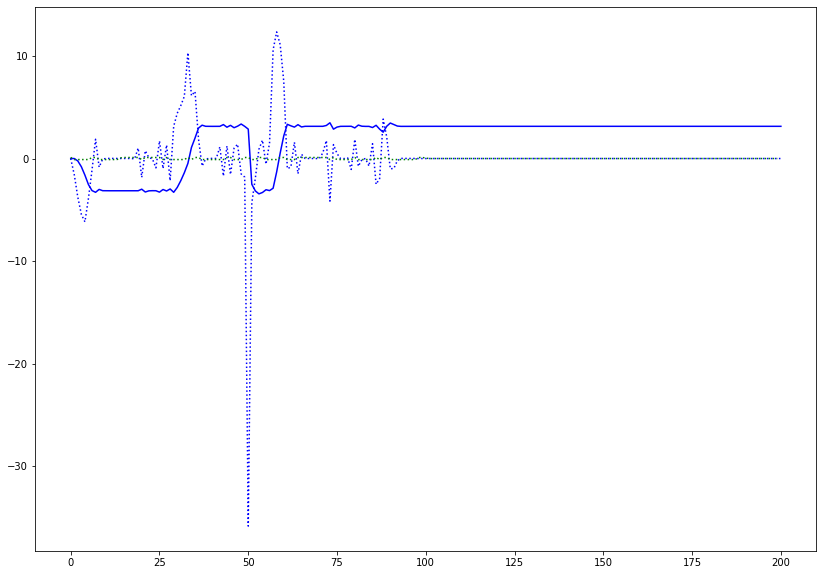

In [138]:
plt.figure(figsize=[14,10])
plt.plot(xx[:,0], 'b')
plt.plot(xx[:,1], 'b:')
plt.plot(uu[:,0], 'g:')

In [120]:
np.round(xx, 4)

array([[ 0.00000e+00,  0.00000e+00, -0.00000e+00,  0.00000e+00],
       [ 0.00000e+00, -1.57510e+00,  0.00000e+00,  3.00000e-02],
       [-4.72500e-01, -6.47600e-01,  9.00000e-03,  1.13371e+01],
       [-6.66800e-01, -2.14720e+00,  3.41010e+00, -2.08470e+00],
       [-1.31100e+00, -5.79870e+00,  2.78470e+00,  1.16610e+00],
       [-3.05060e+00, -2.57300e-01,  3.13460e+00,  5.33000e-02],
       [-3.12780e+00, -1.32300e+00,  3.15060e+00,  6.09000e-02],
       [-3.52470e+00,  2.04380e+00,  3.16880e+00,  3.07700e-01],
       [-2.91160e+00, -3.01200e-01,  3.26110e+00, -2.18600e-01],
       [-3.00190e+00,  1.03260e+00,  3.19560e+00, -5.03100e-01],
       [-2.69220e+00,  4.84270e+00,  3.04460e+00, -9.75400e-01],
       [-1.23930e+00,  1.05008e+01,  2.75200e+00,  2.48900e+00],
       [ 1.91090e+00,  5.67140e+00,  3.49870e+00, -9.38700e-01],
       [ 3.61230e+00, -2.35720e+00,  3.21710e+00, -7.84300e-01],
       [ 2.90520e+00,  5.82700e-01,  2.98180e+00,  2.48000e-02],
       [ 3.08000e+00,  1.

In [130]:
xx.shape

In [133]:
xx[0,:]

array([ 9.46084793e-32,  5.57950083e-32, -1.39028235e-34,  4.45413871e-30])

In [ ]:
euler_step()

In [134]:
for ii in range(N):
    #print(step_rest_2(xx[ii,:], xx[ii+1,:], uu[ii,:], 60/200, [1,1], [1,1], 1))
    print(xx[ii+1,::2]-euler_step(xx[ii,:], 60/200))

[2.38527518e-30 1.39028234e-34]
[0. 0.]
[0.0000000e+00 4.4408921e-16]
[ 0.0000000e+00 -4.4408921e-16]
[4.4408921e-16 0.0000000e+00]
[0.0000000e+00 4.4408921e-16]
[4.4408921e-16 0.0000000e+00]
[-4.4408921e-16 -4.4408921e-16]
[0. 0.]
[0. 0.]
[-2.22044605e-16  0.00000000e+00]
[2.22044605e-16 0.00000000e+00]
[0. 0.]
[ 0.0000000e+00 -4.4408921e-16]
[0. 0.]
[0. 0.]
[0. 0.]
[-4.4408921e-16  0.0000000e+00]
[0. 0.]
[0. 0.]
[-5.55111512e-17  0.00000000e+00]
[-2.22044605e-16  0.00000000e+00]
[0. 0.]
[ 0.0000000e+00 -4.4408921e-16]
[0. 0.]
[0. 0.]
[3.33066907e-16 0.00000000e+00]
[-4.4408921e-16  0.0000000e+00]
[4.4408921e-16 0.0000000e+00]
[0. 0.]
[4.4408921e-16 0.0000000e+00]
[-4.4408921e-16  0.0000000e+00]
[0. 0.]
[0.0000000e+00 4.4408921e-16]
[1.11022302e-16 0.00000000e+00]
[-4.4408921e-16  0.0000000e+00]
[0. 0.]
[ 0.0000000e+00 -4.4408921e-16]
[4.4408921e-16 0.0000000e+00]
[-4.4408921e-16  0.0000000e+00]
[ 0.0000000e+00 -4.4408921e-16]
[0. 0.]
[-4.4408921e-16  0.0000000e+00]
[4.4408921e-16 0.0

In [139]:
def create_anim(sol):
    fig, ax = plt.subplots()

    fig.set_size_inches([8,8])
    ax.set_xlim(( -2.5, 2.5))
    ax.set_ylim(( -2.5, 2.5))

    circle1 = plt.Circle((0, 0), 2, color='b', ls = ":", fill=False)
    circle2 = plt.Circle((0, 0), 1, color='b', ls = ":", fill=False)
    ax.add_artist(circle1)
    ax.add_artist(circle2)

    line1, = ax.plot([], [], lw=2)
    line2, = ax.plot([], [], lw=2)
    point1, = ax.plot([], [], marker='o', markersize=15, color="red")
    point2, = ax.plot([], [], marker='o', markersize=15, color="red")
    text = ax.text(0.2, 0, "", fontsize = 12)
    text_2 = ax.text(0.2, -0.15, "", fontsize = 12)
    
    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        point1.set_data([], [])
        point2.set_data([], [])
        text.set_text('')
        return (line1,line2,)
    def animate(i):
        x1 = [0, np.sin(sol.value(X)[i,0])]
        y1 = [0, -np.cos(sol.value(X)[i,0])]
        x2 = [x1[1], x1[1]+np.sin(sol.value(X)[i,2])]
        y2 = [y1[1], y1[1]-np.cos(sol.value(X)[i,2])]
        line1.set_data(x1, y1)    
        point1.set_data(x1[1], y1[1])
        line2.set_data(x2, y2)    
        point2.set_data(x2[1], y2[1])
        text.set_text("U = %.6f" % sol.value(U)[i,0])
        text_2.set_text(r"$\dot{\theta}$" + " = %.6f" % sol.value(X)[i,1])
        return (line1,line2,)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N, interval=20, 
                               blit=True)
    return anim

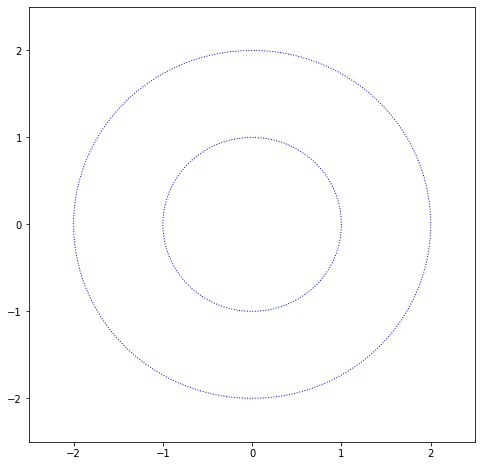

In [140]:
anim = create_anim(sol)

In [141]:
HTML(anim.to_jshtml())